train Assignment 2 Bijayan Ray

In [1]:
import mlflow

mlflow.set_tracking_uri("file:./mlruns")  # Local tracking
mlflow.create_experiment("sms_spam_experiment")
mlflow.set_experiment("sms_spam_experiment")

<Experiment: artifact_location=('file:///A:/partitionD/Downloads/Some Documents/semester 2/applied machine '
 'learning/assignments/assignment 2/mlruns/387370587258839654'), creation_time=1741114885852, experiment_id='387370587258839654', last_update_time=1741114885852, lifecycle_stage='active', name='sms_spam_experiment', tags={}>

# mlflow approach


Logistic Regression Results:
Train Accuracy: 0.9703
Validation Accuracy: 0.9749
Validation AUCPR: 0.9739
Classification Report:
               precision    recall  f1-score   support

    not spam       0.97      1.00      0.99       724
        spam       1.00      0.81      0.90       112

    accuracy                           0.97       836
   macro avg       0.99      0.91      0.94       836
weighted avg       0.98      0.97      0.97       836

Logistic Regression Confusion Matrix for Validation Data:


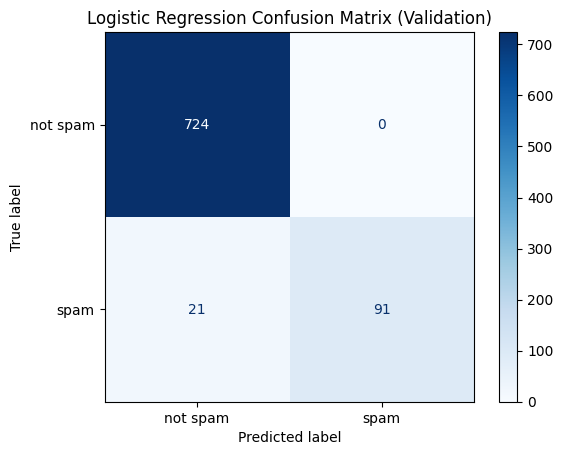


Naive Bayes Results:
Train Accuracy: 0.9821
Validation Accuracy: 0.9761
Validation AUCPR: 0.9782
Classification Report:
               precision    recall  f1-score   support

    not spam       0.97      1.00      0.99       724
        spam       1.00      0.82      0.90       112

    accuracy                           0.98       836
   macro avg       0.99      0.91      0.94       836
weighted avg       0.98      0.98      0.98       836

Naive Bayes Confusion Matrix for Validation Data:


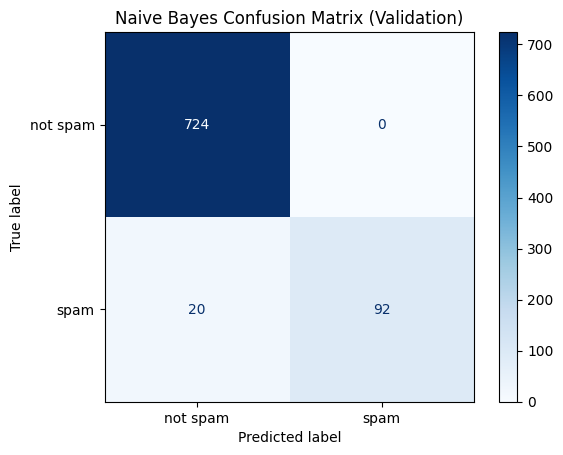

In [ ]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    average_precision_score
)
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import mlflow.models
from mlflow.models.signature import infer_signature

# Set MLflow experiment
mlflow.set_tracking_uri("file:./mlruns")  # Local tracking
mlflow.set_experiment("sms_spam_experiment")

# Load preprocessed train, validation, and test datasets
train_data = pd.read_csv('train.csv')
validation_data = pd.read_csv('validation.csv')
test_data = pd.read_csv('test.csv')

# Combine train and validation data for fine-tuning hyperparameters
train_validation_data = pd.concat([train_data, validation_data])

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train = vectorizer.fit_transform(train_data['message'])
X_validation = vectorizer.transform(validation_data['message'])
X_train_validation = vectorizer.transform(train_validation_data['message'])
X_test = vectorizer.transform(test_data['message'])

# Map labels to "spam" and "not spam"
train_data['label'] = train_data['label'].map({0: "not spam", 1: "spam"})
validation_data['label'] = validation_data['label'].map({0: "not spam", 1: "spam"})
test_data['label'] = test_data['label'].map({0: "not spam", 1: "spam"})
train_validation_data['label'] = train_validation_data['label'].map({0: "not spam", 1: "spam"})

y_train = train_data['label']
y_validation = validation_data['label']
y_train_validation = train_validation_data['label']
y_test = test_data['label']

# Function to evaluate model and log results in MLflow
def evaluate_and_log_model(model, X_train, y_train, X_validation, y_validation, model_name):
    with mlflow.start_run(run_name=model_name):
        # Fit the model
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_validation_pred = model.predict(X_validation)

        # Accuracy Scores
        train_accuracy = accuracy_score(y_train, y_train_pred)
        validation_accuracy = accuracy_score(y_validation, y_validation_pred)

        # Compute AUCPR (Area Under the Precision-Recall Curve)
        y_validation_prob = model.predict_proba(X_validation)[:, 1]  # Probability of "spam"
        aucpr = average_precision_score(y_validation == "spam", y_validation_prob)

        # Print results
        print(f"\n{model_name} Results:")
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Validation Accuracy: {validation_accuracy:.4f}")
        print(f"Validation AUCPR: {aucpr:.4f}")
        print("Classification Report:\n", classification_report(y_validation, y_validation_pred, target_names=["not spam", "spam"]))

        # Plot Confusion Matrix
        print(f"{model_name} Confusion Matrix for Validation Data:")
        cm = confusion_matrix(y_validation, y_validation_pred, labels=["not spam", "spam"])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not spam", "spam"])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"{model_name} Confusion Matrix (Validation)")
        plt.show()

        # Infer model signature
        input_example = X_validation[:1]  # Take a small sample
        signature = infer_signature(input_example.toarray(), model.predict(input_example))

        # Log metrics
        mlflow.log_metric("Train Accuracy", train_accuracy)
        mlflow.log_metric("Validation Accuracy", validation_accuracy)
        mlflow.log_metric("Validation AUCPR", aucpr)

        # Log the model with signature and input example
        mlflow.sklearn.log_model(
            model,
            model_name,
            signature=signature,
            input_example=input_example.toarray()
        )

        return model, aucpr

# Benchmark Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(probability=True)  # Needed for AUCPR
}

# Evaluate and log models
model_aucpr_scores = {}

for model_name, model in models.items():
    trained_model, aucpr = evaluate_and_log_model(model, X_train, y_train, X_validation, y_validation, model_name)
    model_aucpr_scores[model_name] = aucpr

# Select the best model based on AUCPR
best_model_name = max(model_aucpr_scores, key=model_aucpr_scores.get)
best_aucpr = model_aucpr_scores[best_model_name]

print(f"\nBest Model: {best_model_name} with AUCPR: {best_aucpr:.4f}")

# Register the best model in MLflow Model Registry
with mlflow.start_run(run_name=f"Best Model - {best_model_name}"):
    mlflow.log_metric("Best AUCPR", best_aucpr)
    
    # Get the trained best model
    best_model = models[best_model_name]

    # Infer signature for the best model
    input_example = X_validation[:1]
    signature = infer_signature(input_example.toarray(), best_model.predict(input_example))

    # Log and register the best model
    mlflow.sklearn.log_model(
        best_model,
        best_model_name,
        registered_model_name="Best_SMS_Spam_Model",
        signature=signature,
        input_example=input_example.toarray()
    )

    print(f"Registered {best_model_name} as 'Best_SMS_Spam_Model' in MLflow Model Registry")


In [8]:
!git add mlruns/